In [ ]:
%cd /home/junfeng/Documents/WorkSpace/SummerProject/COMP0073_2023_Junfeng

In [2]:
import numpy as np
import torch
import torch.nn as nn

from datasets.posetrack21 import PoseTrack21
from utilities.utilities import keypoints_to_mask, show_image, HiddenPrints, show_heatmaps, keypoints_to_label_flag
from mmpose.evaluation import pose_pck_accuracy, keypoint_pck_accuracy
from mmpose.codecs import UDPHeatmap
from models.backbone.vit_with_fusion import FusionVit
from models.head.deconv import DeconvHead
from models.PoseEstimate import PoseEstimate
from models.head import MaskHead, ResMaskHead

In [4]:
# device = "cpu"
device = "cuda"
pretrained_path = "./checkpoints/vitpose_base_coco_aic_mpii.pth"
encoder = FusionVit(pretrained_path=pretrained_path)
neck = nn.Identity()
head = DeconvHead(pretrained_path=pretrained_path)
model = PoseEstimate(encoder=encoder, neck=neck, head=head)
model.to(device)
model_path = "./checkpoints/Fusion_Deconv_02.pth"
model_dict = torch.load(model_path, map_location=device)
model.load_state_dict(model_dict["model_state_dict"])
epoch = model_dict["epoch"]
print(f"Loaded model from {model_path} at epoch {epoch}")
with HiddenPrints():
    model.to(device)
    model.eval()

Loaded model from ./checkpoints/Fusion_Deconv_02.pth at epoch 2480


In [5]:
dataset_root_dir = "/home/junfeng/datasets/PoseTrack21"
dataset_train = PoseTrack21(
    root_dir=dataset_root_dir,
    set="train",
)

dataset_test = PoseTrack21(
    root_dir=dataset_root_dir,
    set="test",
)

print(len(dataset_train))
print(len(dataset_test))

593
170


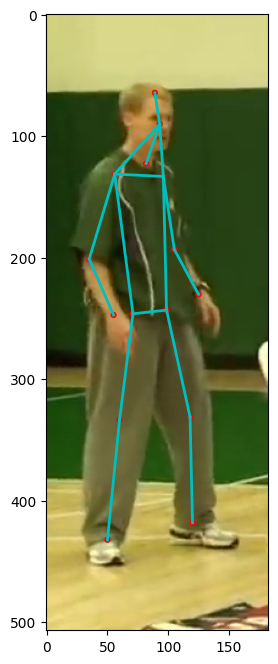

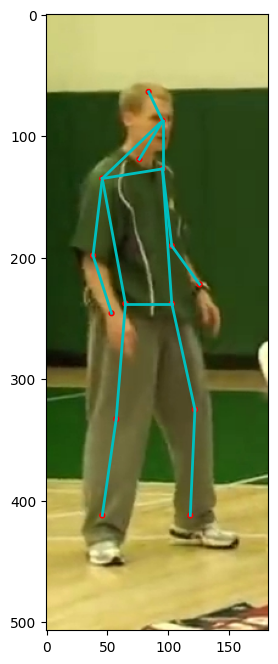

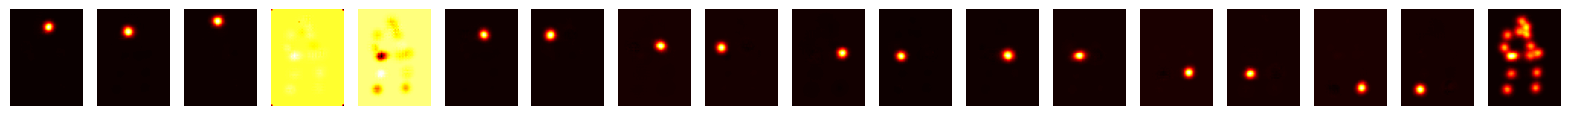

In [63]:
dataset = dataset_test
loss_val = 0
acc = 0
count = 0
i = np.random.randint(0, len(dataset))
video, video_transformed, keypoints, keypoints_transformed, heatmaps = dataset[i]
image = video[1]
H, W, _ = image.shape
decoder = UDPHeatmap(input_size=(W, H), heatmap_size=(48, 64))
image_transformed = video_transformed[1]
video_transformed = video_transformed.to(device).unsqueeze(0)
show_image(image, keypoints)
with torch.no_grad():
    pred_heatmaps = model.predict(video_transformed)
    show_image(image, heatmaps=pred_heatmaps.squeeze(0).cpu().numpy())
    show_heatmaps(pred_heatmaps.squeeze(0).cpu().numpy())
    